# Importing the Data 

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns

url = 'https://fantasy.premierleague.com/api/bootstrap-static/'
r = requests.get(url)
json = r.json()

In [2]:
# Converting the 3 json files into 3 seperate dataframes

df_teams = pd.DataFrame(json['teams'])
df_elements = pd.DataFrame(json['elements'])
df_element_types = pd.DataFrame(json['element_types'])


In [3]:
df_teams = df_teams[['id' , 'name']]

df_elements = df_elements[['web_name' , 'total_points', 'points_per_game' ,'now_cost', 'value_season', 
                          'team','element_type' , 'form','goals_scored' , 'minutes' , 'assists' , 'clean_sheets' , 'goals_conceded' , 'chance_of_playing_next_round']]

df_element_types = df_element_types[['id' , 'plural_name_short']]



In [4]:
# Rename columns of tables in order to merge them

df_elements = df_elements.rename(columns = {'web_name':'Player' , 'now_cost':'Cost' , 'value_season' : 'ROI' , 'element_type':'position'})
df_element_types = df_element_types.rename(columns = {'id':'position'})
df_teams = df_teams.rename(columns = {'id':'team' , 'name':'Team'})
df = pd.merge(df_elements , df_element_types , on = 'position')
df = pd.merge(df , df_teams , on = 'team')
df = df.drop(columns = ['team' , 'position'])
df = df.rename(columns = {'plural_name_short' : 'Position' , 'Player':'PLAYER' , 'total_points':'TOTAL_POINTS',
                         'points_per_game':'POINTS_PER_GAME' , 'Cost':'COST' , 'team':'TEAM' , 'position':'POSITION',
                         'form':'FORM' , 'goals_scored':'GOALS_SCORED' , 'minutes':'MINUTES' , 'assists' : 'ASSISTS',
                         'goals_scored': 'GOALS_SCORED' , 'minutes':'MINUTES' , 'assists':'ASSISTS', 'clean_sheets':'CLEAN_SHEETS',
                         'goals_conceded':'GOALS_CONCEDED' , 'Position': 'POSITION' , 'Team':'TEAM'})

df['COST'] = df['COST']/10
df['ROI'] = df['ROI'].astype('float')
df['POINTS_PER_GAME'] = df['POINTS_PER_GAME'].astype('float')
df['FORM'] = df['FORM'].astype('float')

In [5]:
# Limiting our analysis on players who have played more than 800 minutes (almost half of the games), to show that they are regulars

df = df[df['MINUTES'] >= 650]



In [6]:
# Take into consideration other factors, like upcoming fixture difficulties 

df_team_fixtures = pd.read_excel('/Users/anthonymoubarak/Desktop/FPL Project/teams_fixtures.xlsx')
df_team_fixtures = df_team_fixtures.rename(columns = {'Team':'TEAM'})
df = pd.merge(df ,df_team_fixtures, on = ['TEAM'])
df = df.drop(columns=['team'])
df = df.rename(columns = {'Total':'FIXTURE_DIFFICULTY'})


# Exploratory Analysis

In [7]:
# Create a list of the top players (highest points so far) that might be used later on

top_players_points = df.sort_values(by = ['TOTAL_POINTS'] , ascending = False)

# Created a list of the top players (highest roi so far) that might be used later on

top_players_roi = df.sort_values(by = ['ROI'] , ascending = False)


# Filter out players that have hard upcoming fixtures (not for superstars since they are usually consistent)

top_players_roi = top_players_roi[(top_players_roi['FIXTURE_DIFFICULTY'] >= 0) & (top_players_roi['FORM'] >= 2.6)]



In [8]:
# Converting all columns to numeric

df['ROI'] = df['ROI'].astype('float')

df['POINTS_PER_GAME'] = df['POINTS_PER_GAME'].astype('float')

df['FORM'] = df['FORM'].astype('float')

top_players_points['POINTS_PER_GAME'] = top_players_points['POINTS_PER_GAME'].astype('float')

top_players_points['FORM'] = top_players_points['FORM'].astype('float')

top_players_roi['POINTS_PER_GAME'] = top_players_roi['POINTS_PER_GAME'].astype('float')

top_players_roi['FORM'] = top_players_roi['FORM'].astype('float')

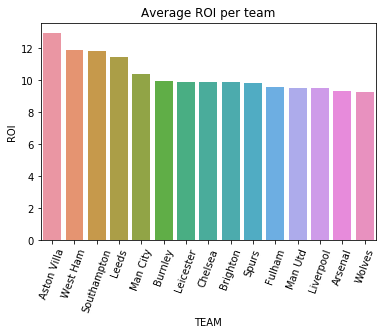

In [9]:
# Created a list and bar chart of the top 15 teams in terms of total ROI


total_teams_roi = pd.DataFrame(df.groupby('TEAM')['ROI'].mean()).sort_values(by = ['ROI'] , ascending = False)[0:15]
chart = sns.barplot(x = total_teams_roi.index , y = 'ROI' , data = total_teams_roi )
plt.xticks(rotation=70)
plt.title('Average ROI per team')

# figure size in inches

from matplotlib import rcParams

rcParams['figure.figsize'] = 15,10


In [10]:
df['Position'].value_counts()

# Since forwards (82) and gk (74) are much less than mid and def, we should compare average roi and not total

MID    122
DEF    101
FWD     34
GKP     21
Name: Position, dtype: int64

Text(0, 0.5, 'Average ROI')

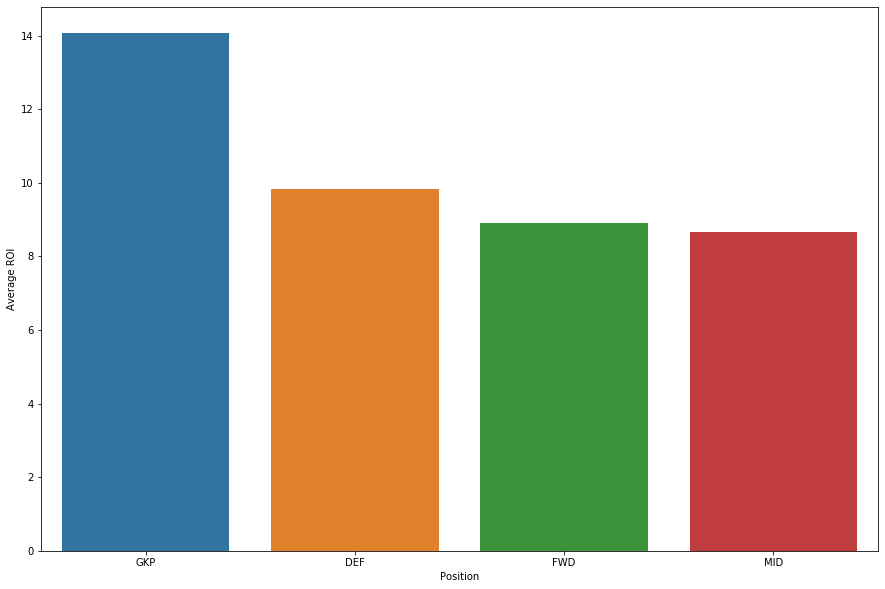

In [11]:
# We want to plot the highets valuable (in terms of average ROI) poistions 


top_positions_roi = pd.pivot_table(df , index = ['Position'] , values = ['ROI'], aggfunc=np.mean).sort_values(by=['ROI'] , ascending = False)
sns.barplot(x = top_positions_roi.index  , y = "ROI" , data = top_positions_roi)
plt.ylabel('Average ROI')

Text(0.5, 1.0, 'Top 20 players (highest Points)')

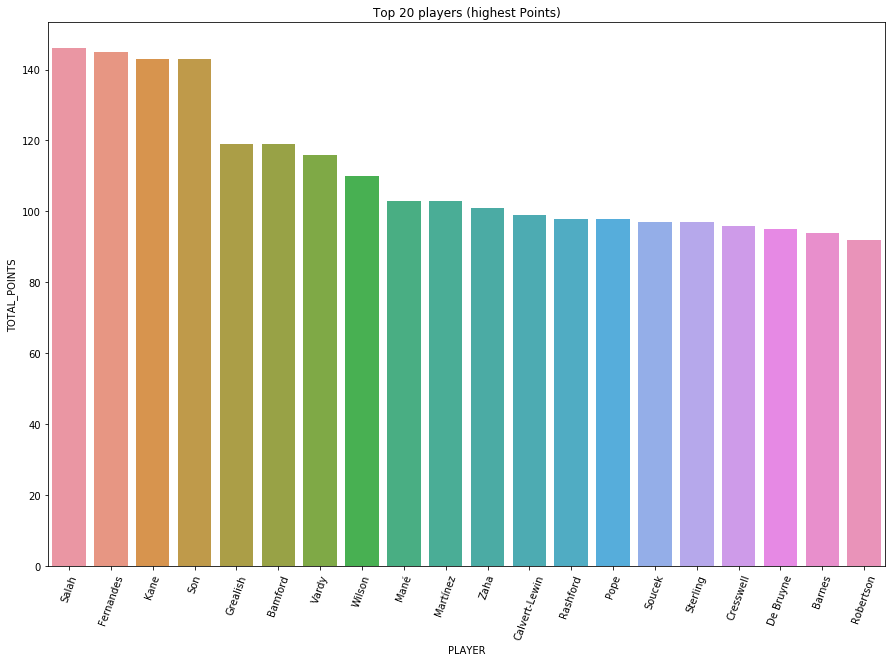

In [12]:
sns.barplot(x = top_players_points['PLAYER'][0:20]  , y = "TOTAL_POINTS" , data = top_players_points[0:20])
plt.xticks(rotation=70)
plt.title('Top 20 players (highest Points)')



Text(0.5, 1.0, 'Top 20 players (highest ROI)')

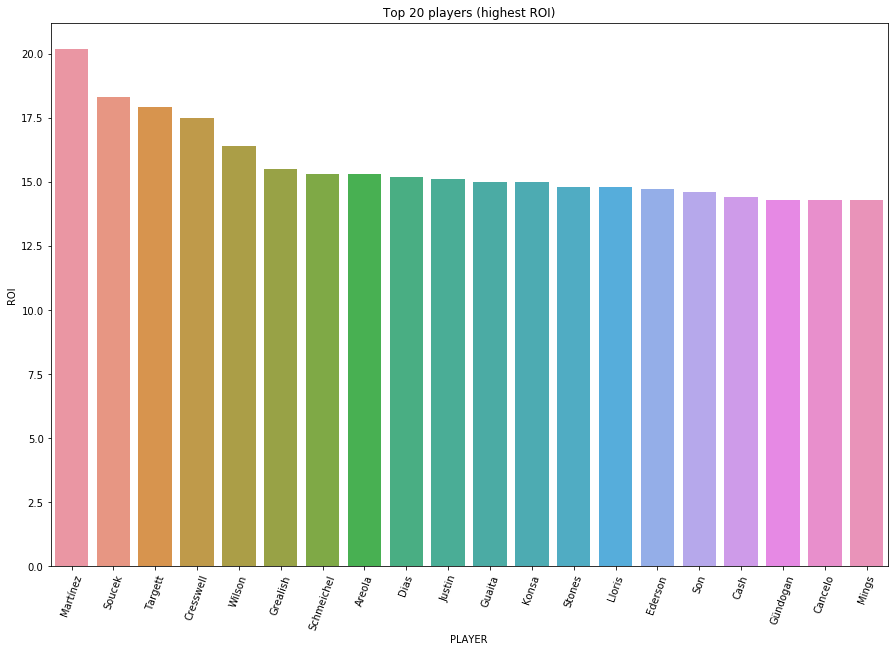

In [13]:
#The top 20 players in terms of ROI



sns.barplot(x = top_players_roi['PLAYER'][0:20]  , y = "ROI" , data = top_players_roi[0:20])
plt.xticks(rotation=70)
plt.title('Top 20 players (highest ROI)')



In [14]:
# Remove all players that are not going to play for sure 


top_players_roi = top_players_roi[top_players_roi['chance_of_playing_next_round'] != 0]
                                
top_players_roi = top_players_roi[top_players_roi['chance_of_playing_next_round'] != 50]

top_players_roi = top_players_roi[top_players_roi['chance_of_playing_next_round'] != 75]



top_players_points = top_players_points[top_players_points['chance_of_playing_next_round'] != 0]
                                
top_players_points = top_players_points[top_players_points['chance_of_playing_next_round'] != 50]

top_players_points = top_players_points[top_players_points['chance_of_playing_next_round'] != 75]

In [15]:
top_players_points

,PLAYER,TOTAL_POINTS,POINTS_PER_GAME,COST,ROI,FORM,GOALS_SCORED,MINUTES,ASSISTS,CLEAN_SHEETS,GOALS_CONCEDED,chance_of_playing_next_round,Position,TEAM,Unnamed: 0,Game 1,Game 2,Game 3,FIXTURE_DIFFICULTY
144,Salah,146,7.3,12.6,11.6,4.6,15,1651,4,5,23,100.0,MID,Liverpool,10,0,1,-1,0
168,Fernandes,145,6.9,11.4,12.7,3.0,11,1745,9,7,22,NaN,MID,Man Utd,12,0,0,0,0
222,Son,143,7.2,9.8,14.6,4.8,12,1706,6,8,15,100.0,MID,Spurs,16,1,-1,1,1
15,Grealish,119,6.3,7.7,15.5,5.5,6,1707,11,10,21,NaN,MID,Aston Villa,1,1,0,0,1
191,Wilson,110,5.8,6.7,16.4,4.3,10,1687,5,5,28,100.0,FWD,Newcastle,13,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,Livermore,20,1.4,4.7,4.3,1.6,0,1112,0,1,32,100.0,MID,West Brom,17,1,1,-1,1
196,Osborn,19,1.6,4.8,4.0,1.0,0,765,0,1,13,25.0,MID,Sheffield Utd,14,-2,1,-1,-2
246,Ivanovic,18,1.6,4.4,4.1,0.0,0,741,0,2,18,100.0,DEF,West Brom,17,1,1,-1,1
245,O'Shea,13,0.8,4.3,3.0,0.4,0,1293,0,0,41,NaN,DEF,West Brom,17,1,1,-1,1


# The Algorithm (Wildcard)

In [16]:
# Setting the conditions
gk = 2
mid = 5
fwd = 3
same_team = 3 # max of 3 (<= 3)
star_player = 3 # Total number of star players wanted in the team 

my_team = [] # List of names of team created 



    
star_players = top_players_points.sort_values(by = ['FORM'] , ascending = False)


def create_team(same_team = 3 , star_players = 3, gk = 2 ,df = 5,  mid = 5, fwd = 3):
    
     
    # Teams of players added to list 
    teams = []
    
    # We need the budget to be user inputted
    
    budget = float(input('How much money is in your bank ? '))
    
    
    # Creating a dictionary that sets position limits 
    
    positions = { 'GKP': gk , 'DEF': df , 'MID': mid, 'FWD': fwd }
    
    for player in top_players_points.index:
        
        if len(my_team) < star_players and budget >= top_players_points.COST[player] and positions[top_players_points.Position[player]] > 0 and top_players_points.PLAYER[player] not in my_team and teams.count(top_players_points.TEAM[player]) < 3:
            
            my_team.append(top_players_points.PLAYER[player])
            
            budget = budget - top_players_points.COST[player]
            
            positions[top_players_points.Position[player]] = positions[top_players_points.Position[player]] - 1
            
            teams.append(top_players_points.TEAM[player])
            
            
        else:
            
            for player in top_players_roi.index:
                
                if len(my_team) < 15 and budget >= top_players_roi.COST[player] and positions[top_players_roi.Position[player]] > 0 and top_players_roi.PLAYER[player] not in my_team and teams.count(top_players_roi.TEAM[player]) < 3:
                    
                    my_team.append(top_players_roi.PLAYER[player])
                    
                    budget = budget - top_players_roi.COST[player]
                    
                    positions[top_players_roi.Position[player]] = positions[top_players_roi.Position[player]] - 1
                    
                    teams.append(top_players_roi.TEAM[player])
    
    
   
        
                    
    return my_team
            

       
   

In [17]:
create_team()

How much money is in your bank ? 101.4


['Salah',
 'Fernandes',
 'Son',
 'Martínez',
 'Soucek',
 'Targett',
 'Cresswell',
 'Wilson',
 'Grealish',
 'Schmeichel',
 'Dias',
 'Justin',
 'Stones',
 'Callum Robinson']

In [18]:
# Setting the conditions
gk = 2
mid = 5
fwd = 3
same_team = 3 # max of 3 (<= 3)
star_player = 3 # Total number of star players wanted in the team 

my_team2 = [] # List of names of team created 



    
star_players = top_players_points.sort_values(by = ['FORM'] , ascending = False)


def create_team2(same_team = 3 , star_players = 3, gk = 2 ,df = 5,  mid = 5, fwd = 3):
    
     
    # Teams of players added to list 
    teams = []
    
    # We need the budget to be user inputted
    
    budget = float(input('How much money is in your bank ? '))
    
    
    # Creating a dictionary that sets position limits 
    
    positions = { 'GKP': gk , 'DEF': df , 'MID': mid, 'FWD': fwd }
    
    for player in top_players_points.index:
        
        if len(my_team2) < 15 and budget >= top_players_points.COST[player] and positions[top_players_points.Position[player]] > 0 and top_players_points.PLAYER[player] not in my_team2 and teams.count(top_players_points.TEAM[player]) < 3:
            
            my_team2.append(top_players_points.PLAYER[player])
            
            budget = budget - top_players_points.COST[player]
            
            positions[top_players_points.Position[player]] = positions[top_players_points.Position[player]] - 1
            
            teams.append(top_players_points.TEAM[player])
            
            
        else:
            
            for player in top_players_roi.index:
                
                if len(my_team2) < 15 and budget >= top_players_roi.COST[player] and positions[top_players_roi.Position[player]] > 0 and top_players_roi.PLAYER[player] not in my_team2 and teams.count(top_players_roi.TEAM[player]) < 3:
                    
                    my_team2.append(top_players_roi.PLAYER[player])
                    
                    budget = budget - top_players_roi.COST[player]
                    
                    positions[top_players_roi.Position[player]] = positions[top_players_roi.Position[player]] - 1
                    
                    teams.append(top_players_roi.TEAM[player])
    
    
   
        
                    
    return my_team2
            

       
   

In [19]:
create_team2()

How much money is in your bank ? 101.4


['Salah',
 'Fernandes',
 'Son',
 'Grealish',
 'Wilson',
 'Martínez',
 'Zaha',
 'Calvert-Lewin',
 'Targett',
 'Cresswell',
 'Schmeichel',
 'Dias',
 'Justin',
 'Stones']

In [54]:
# Store results in a dataframe

final_team_player = np.array([])
final_team_cost = np.array([],dtype = 'float')
final_team_roi = np.array([], dtype = 'float')
final_team_total_points = np.array([], dtype = 'int')
final_team_team= np.array([], dtype = 'str')

final_team_cost.astype('float')
final_team_roi.astype('float')
final_team_total_points.astype('int')

for i in my_team:
    
    final_team_player = np.append(final_team_player, i)
    final_team_cost = np.append(final_team_cost, df[df['PLAYER'] == i].COST)
    final_team_total_points = np.append(final_team_total_points , df[df['PLAYER'] == i].TOTAL_POINTS)
    final_team_roi = np.append(final_team_roi , df[df['PLAYER'] == i].ROI)
    final_team_team = np.append(final_team_team , df[df['PLAYER'] == i].TEAM)
    
    
    
    
#final_team_team = np.delete(final_team_team , 13)
#final_team_cost = np.delete(final_team_cost , 13) 
#final_team_roi = np.delete(final_team_roi , 13) 
#final_team_total_points = np.delete(final_team_total_points , 13) 
final_team_dict = {'Player':final_team_player , 'Cost':final_team_cost,
                  'Total_points':final_team_total_points, 'ROI':final_team_roi, 'Team': final_team_team }    
    
    
                   
                   
                 

Final_team = pd.DataFrame(final_team_dict)
                          
x1 = Final_team.ROI.sum()
x11 = Final_team.Total_points.sum()
x11



1496

In [55]:
# Store results in a dataframe

final_team_player = np.array([])
final_team_cost = np.array([],dtype = 'float')
final_team_roi = np.array([], dtype = 'float')
final_team_total_points = np.array([], dtype = 'int')
final_team_team= np.array([], dtype = 'str')

final_team_cost.astype('float')
final_team_roi.astype('float')
final_team_total_points.astype('int')

for i in my_team2:
    
    final_team_player = np.append(final_team_player, i)
    final_team_cost = np.append(final_team_cost, df[df['PLAYER'] == i].COST)
    final_team_total_points = np.append(final_team_total_points , df[df['PLAYER'] == i].TOTAL_POINTS)
    final_team_roi = np.append(final_team_roi , df[df['PLAYER'] == i].ROI)
    final_team_team = np.append(final_team_team , df[df['PLAYER'] == i].TEAM)
    
    
    
    
#final_team_team = np.delete(final_team_team , 13)
#final_team_cost = np.delete(final_team_cost , 13) 
#final_team_roi = np.delete(final_team_roi , 13) 
#final_team_total_points = np.delete(final_team_total_points , 13) 
final_team_dict = {'Player':final_team_player , 'Cost':final_team_cost,
                  'Total_points':final_team_total_points, 'ROI':final_team_roi, 'Team': final_team_team }    
    
    
                   
                   
                 

Final_team = pd.DataFrame(final_team_dict)
                          
x2 = Final_team.ROI.sum()
x22 = Final_team.Total_points.sum()
x22

1400

Text(0.5, 1.0, 'Total ROI of my algorithm vs Alternate algorithm')

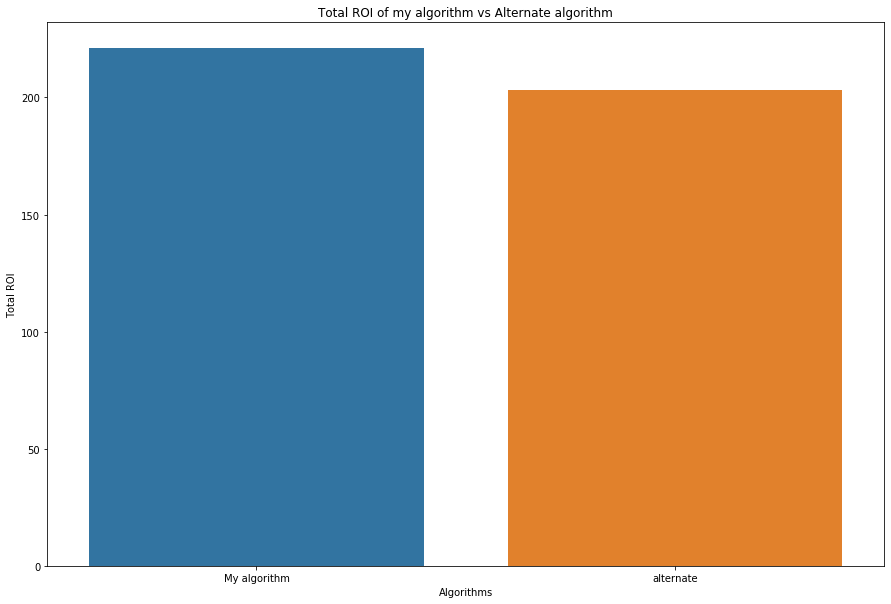

In [50]:
# Comparing total ROI of both algorithms 

comparison = {'Algorithms' : ['My algorithm' , 'alternate'] , 'Total ROI':[x1 , x2]}
comp_df = pd.DataFrame(comparison)
sns.barplot(x = 'Algorithms' , y ='Total ROI' , data = comp_df)
plt.title('Total ROI of my algorithm vs Alternate algorithm')

Text(0.5, 1.0, 'Total points of my algorithm vs Alternate algorithm')

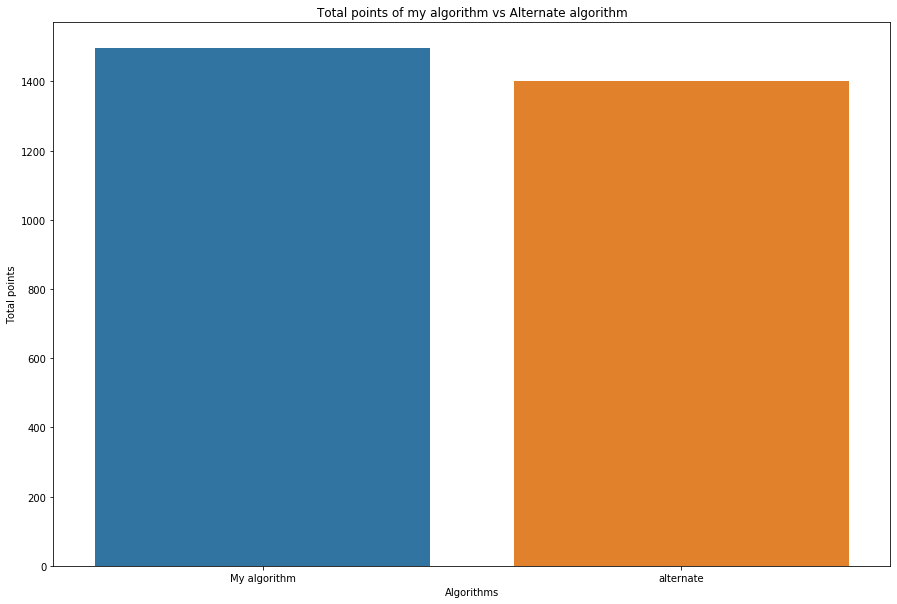

In [57]:
# Comparing total points of both algorithms 

comparison = {'Algorithms' : ['My algorithm' , 'alternate'] , 'Total points':[x11 , x22]}
comp_df = pd.DataFrame(comparison)
sns.barplot(x = 'Algorithms' , y ='Total points' , data = comp_df)
plt.title('Total points of my algorithm vs Alternate algorithm')

Text(0.5, 1.0, 'Final Team Composition')

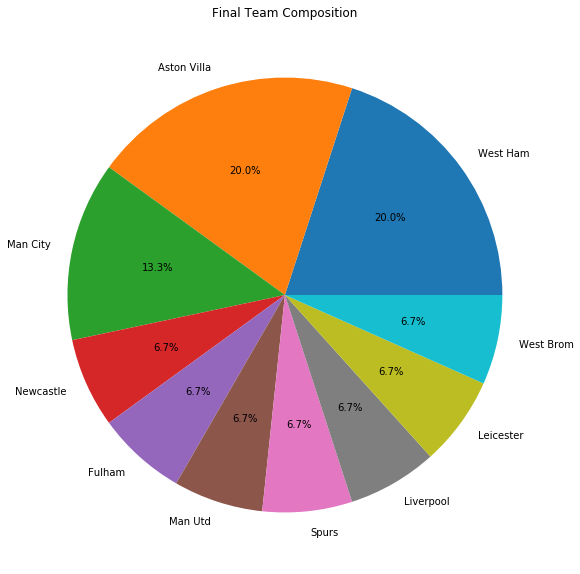

In [23]:
# Checking the distribution of teams in our final team

team_distribution = pd.DataFrame(Final_team.Team.value_counts())
my_labels = team_distribution.index 
values = team_distribution['Team']
sizes = [15, 30, 45, 10]

fig1, ax1 = plt.subplots()
plt.pie(values , labels= my_labels, autopct='%1.1f%%')
plt.title('Final Team Composition')



# Transfer Bot

In [20]:
# 1) We need to build a transfer bot, where we give it our team of 15 players, tells us which 1 player to remove and 
# with which player to replace him with.

# 2) Since ROI = Total_Points/Cost, it takes into consideration the performances from gameweek 1 till the current 
# gameweek, which makes it kind of irrelevant since we should focus more on current player forms.

# 3) Consequently, a new metric, ROI_form should be defined as form/cost, where form = (Points per game for the past 30 days)/Cost
# this way, we would ensure that a player's current form is the most important factor when we want to choose which player to remove

# 4) Additionally, we should take into consideration upcoming fixtures when picking which players to remove/add.

# 5) Star players usually perform even in big games (-1 games), so next game's difficulty will be taken into consideration
# only for normal players.

## 1) Transfer out

In [21]:
df['ROI_Form'] = round(df['FORM']/df['COST'] , 2)

In [26]:
def transfer_out():
    
    # Prompt for user input, to enter their current team.

    user_team_input = input('Enter your 15 player team: ')
    
    while len(user_team_input.split(",")) != 15:
        print('Error !')
        user_team_input = input('Enter your 15 player team: ')
    
    
    user_team = user_team_input.split(',')   
    
    
    # We should create a dataframe of the inputted team in order to carry on with further analysis
    user_team_player = np.array([])
    
    user_team_cost = np.array([],dtype = 'float')
    
    user_team_roi = np.array([], dtype = 'float')
    
    user_team_total_points = np.array([], dtype = 'int')
    
    user_team_team= np.array([], dtype = 'str')
    
    user_team_form = np.array([], dtype = 'float')
    
    user_team_roi_form = np.array([], dtype = 'float')
    
    # Remove spaces from player names 
    
    for i in np.arange(len(user_team)):
        
        user_team[i] = user_team[i].split(" ")[len(user_team[i].split(" ")) - 1]
        
    for i in user_team:
        user_team_player = np.append(user_team_player, i)
        
        user_team_cost = np.append(user_team_cost, df[df['PLAYER'] == i].COST)
        
        user_team_total_points = np.append(user_team_total_points , df[df['PLAYER'] == i].TOTAL_POINTS)
        
        user_team_roi = np.append(user_team_roi , df[df['PLAYER'] == i].ROI)
        
        user_team_team = np.append(user_team_team , df[df['PLAYER'] == i].TEAM)
        
        user_team_form = np.append(user_team_form , df[df['PLAYER'] == i].FORM)
        
        user_team_roi_form = np.append(user_team_roi_form , df[df['PLAYER'] == i].ROI_Form)
        
    #user_team_team = np.delete(user_team_team , 13)
    #user_team_cost = np.delete(user_team_cost , 13) 
    #user_team_roi = np.delete(user_team_roi , 13) 
    #user_team_form = np.delete(user_team_form , 13)
    #user_team_total_points = np.delete(user_team_total_points , 13)
    #user_team_roi_form = np.delete(user_team_roi_form , 13)
    

    user_team_dict = {'Player':user_team_player , 'Cost':user_team_cost,
                  'Total_points': user_team_total_points, 'ROI':user_team_roi, 'Team': user_team_team,
                  'Form': user_team_form, 'ROI_Form': user_team_roi_form }
    
    user_team_df = pd.DataFrame(user_team_dict)
    
    
    # Add upcoming fixtures df to the dataframe
    
    fixtures = pd.read_excel('/Users/anthonymoubarak/Desktop/FPL Project/teams_fixtures.xlsx') 
    
    user_team_df = pd.merge(user_team_df , fixtures , on = ['Team'] )
    
    user_team_df = user_team_df.drop(columns = ['team'])
    
    user_team_df = user_team_df.sort_values(by = ['ROI_Form'] , ascending = False)
    
    
    # Now we should take into consideration the difficulty of the upcoming game for all players 
    # We can add the difficulty to the ROI_form, we will call the result ROI_DIFF


    user_team_df['ROI_DIFF'] = user_team_df['ROI_Form'] + user_team_df['Game 1']
    
    
    # Plot the bar plot again, with the new factor as our main one

    user_team_df = user_team_df.sort_values(by = ['ROI_DIFF'] , ascending = False)

    graph = sns.barplot(x = user_team_df.Player , y = user_team_df.ROI_DIFF , data = user_team_df )
    sns.set(rc={'figure.figsize':(30,22)})
    plt.xlabel('Player' , fontsize = 25)
    plt.ylabel('Difficulty index' , fontsize = 25)
    plt.title('Player Performance based on ROI_form and next game' , fontsize = 25)
   

    # Add a horizontal line = to the mean 

    graph.axhline(user_team_df['ROI_DIFF'].mean())
    
    print('')
    print('')
    print('')
    print('')
    print('According to his recent form and overall return on investment, as well as his upcoming game you should transfer '
                       ,  user_team_df[user_team_df['ROI_DIFF'] == user_team_df['ROI_DIFF'].min()].Player )
    
    return graph
                      
 

Enter your 15 player team: Fernandes, Kane, Son, Martínez, Soucek, Cresswell, Targett, Fabianski, Justin, Stones, Grealish, Cancelo, Gündogan, Callum Robinson, Benteke




According to his recent form and overall return on investment, as well as his upcoming game you should transfer  8    Fabianski
Name: Player, dtype: object


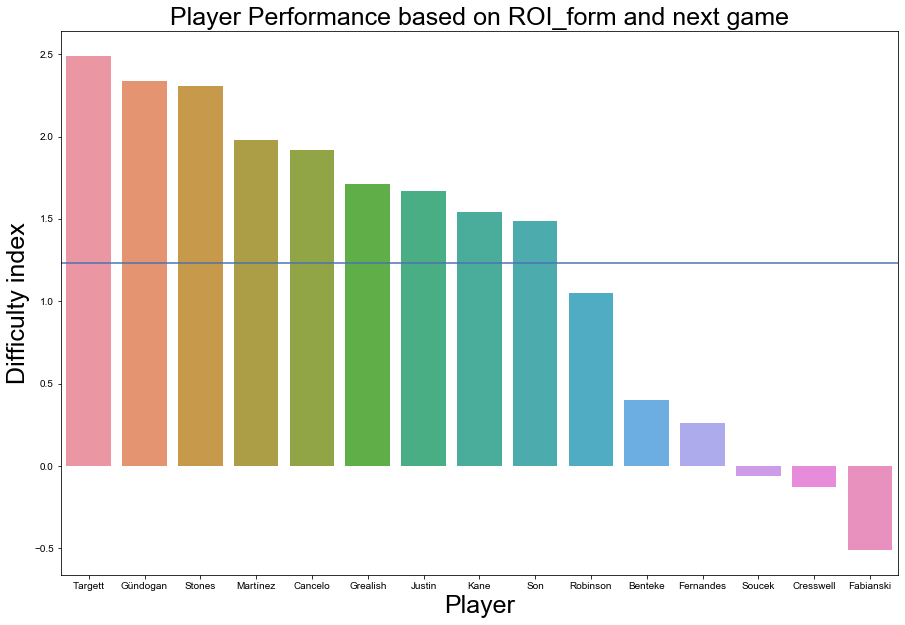

In [28]:
transfer_out()

## Transfer in

## Fbref Scraper

In [29]:

# We will use webscrapping in order to get updated data from fbref
# Reference to the github link of the scraper is inserted below
# URL = 'https://github.com/parth1902/Scrape-FBref-data/blob/master/Scrape_FBref.ipynb'


import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import sys, getopt
import csv

#standard(stats)
stats = ["player","nationality","position","squad","age","birth_year","games","games_starts","minutes","goals","assists","pens_made","pens_att","cards_yellow","cards_red","goals_per90","assists_per90","goals_assists_per90","goals_pens_per90","goals_assists_pens_per90","xg","npxg","xa","xg_per90","xa_per90","xg_xa_per90","npxg_per90","npxg_xa_per90"]
stats3 = ["players_used","possession","games","games_starts","minutes","goals","assists","pens_made","pens_att","cards_yellow","cards_red","goals_per90","assists_per90","goals_assists_per90","goals_pens_per90","goals_assists_pens_per90","xg","npxg","xa","xg_per90","xa_per90","xg_xa_per90","npxg_per90","npxg_xa_per90"] 

#shooting(shooting)
shooting = ["player","nationality","position","squad","age","birth_year","minutes_90s","goals","pens_made","pens_att","shots_total","shots_on_target","shots_free_kicks","shots_on_target_pct","shots_total_per90","shots_on_target_per90","goals_per_shot","goals_per_shot_on_target","xg","npxg","npxg_per_shot","xg_net","npxg_net"]
shooting2 = ["minutes_90s","goals","pens_made","pens_att","shots_total","shots_on_target","shots_free_kicks","shots_on_target_pct","shots_total_per90","shots_on_target_per90","goals_per_shot","goals_per_shot_on_target","xg","npxg","npxg_per_shot","xg_net","npxg_net"]
shooting3 = ["goals","pens_made","pens_att","shots_total","shots_on_target","shots_free_kicks","shots_on_target_pct","shots_total_per90","shots_on_target_per90","goals_per_shot","goals_per_shot_on_target","xg","npxg","npxg_per_shot","xg_net","npxg_net"]

#passing(passing)
passing = ["player","nationality","position","squad","age","birth_year","minutes_90s","passes_completed","passes","passes_pct","passes_total_distance","passes_progressive_distance","passes_completed_short","passes_short","passes_pct_short","passes_completed_medium","passes_medium","passes_pct_medium","passes_completed_long","passes_long","passes_pct_long","assists","xa","xa_net","assisted_shots","passes_into_final_third","passes_into_penalty_area","crosses_into_penalty_area","progressive_passes"]
passing2 = ["passes_completed","passes","passes_pct","passes_total_distance","passes_progressive_distance","passes_completed_short","passes_short","passes_pct_short","passes_completed_medium","passes_medium","passes_pct_medium","passes_completed_long","passes_long","passes_pct_long","assists","xa","xa_net","assisted_shots","passes_into_final_third","passes_into_penalty_area","crosses_into_penalty_area","progressive_passes"]



#defensive actions(defense)
defense = ["player","nationality","position","squad","age","birth_year","minutes_90s","tackles","tackles_won","tackles_def_3rd","tackles_mid_3rd","tackles_att_3rd","dribble_tackles","dribbles_vs","dribble_tackles_pct","dribbled_past","pressures","pressure_regains","pressure_regain_pct","pressures_def_3rd","pressures_mid_3rd","pressures_att_3rd","blocks","blocked_shots","blocked_shots_saves","blocked_passes","interceptions","clearances","errors"]
defense2 = ["tackles","tackles_won","tackles_def_3rd","tackles_mid_3rd","tackles_att_3rd","dribble_tackles","dribbles_vs","dribble_tackles_pct","dribbled_past","pressures","pressure_regains","pressure_regain_pct","pressures_def_3rd","pressures_mid_3rd","pressures_att_3rd","blocks","blocked_shots","blocked_shots_saves","blocked_passes","interceptions","clearances","errors"]


#Functions to get the data in a dataframe using BeautifulSoup

def get_tables(url):
    res = requests.get(url)
    ## The next two lines get around the issue with comments breaking the parsing.
    comm = re.compile("<!--|-->")
    soup = BeautifulSoup(comm.sub("",res.text),'lxml')
    all_tables = soup.findAll("tbody")
    team_table = all_tables[0]
    player_table = all_tables[1]
    return player_table, team_table

def get_frame(features, player_table):
    pre_df_player = dict()
    features_wanted_player = features
    rows_player = player_table.find_all('tr')
    for row in rows_player:
        if(row.find('th',{"scope":"row"}) != None):
    
            for f in features_wanted_player:
                cell = row.find("td",{"data-stat": f})
                a = cell.text.strip().encode()
                text=a.decode("utf-8")
                if(text == ''):
                    text = '0'
                if((f!='player')&(f!='nationality')&(f!='position')&(f!='squad')&(f!='age')&(f!='birth_year')):
                    text = float(text.replace(',',''))
                if f in pre_df_player:
                    pre_df_player[f].append(text)
                else:
                    pre_df_player[f] = [text]
    df_player = pd.DataFrame.from_dict(pre_df_player)
    return df_player

def get_frame_team(features, team_table):
    pre_df_squad = dict()
    #Note: features does not contain squad name, it requires special treatment
    features_wanted_squad = features
    rows_squad = team_table.find_all('tr')
    for row in rows_squad:
        if(row.find('th',{"scope":"row"}) != None):
            name = row.find('th',{"data-stat":"squad"}).text.strip().encode().decode("utf-8")
            if 'squad' in pre_df_squad:
                pre_df_squad['squad'].append(name)
            else:
                pre_df_squad['squad'] = [name]
            for f in features_wanted_squad:
                cell = row.find("td",{"data-stat": f})
                a = cell.text.strip().encode()
                text=a.decode("utf-8")
                if(text == ''):
                    text = '0'
                if((f!='player')&(f!='nationality')&(f!='position')&(f!='squad')&(f!='age')&(f!='birth_year')):
                    text = float(text.replace(',',''))
                if f in pre_df_squad:
                    pre_df_squad[f].append(text)
                else:
                    pre_df_squad[f] = [text]
    df_squad = pd.DataFrame.from_dict(pre_df_squad)
    return df_squad

def frame_for_category(category,top,end,features):
    url = (top + category + end)
    player_table, team_table = get_tables(url)
    df_player = get_frame(features, player_table)
    return df_player

def frame_for_category_team(category,top,end,features):
    url = (top + category + end)
    player_table, team_table = get_tables(url)
    df_team = get_frame_team(features, team_table)
    return df_team



#Function to get the player data for outfield player, includes all categories - standard stats, shooting
#passing, passing types, goal and shot creation, defensive actions, possession, and miscallaneous
def get_outfield_data(top, end):
    df1 = frame_for_category('stats',top,end,stats)
    df2 = frame_for_category('shooting',top,end,shooting2)
    df3 = frame_for_category('passing',top,end,passing2)
    df4 = frame_for_category('defense',top,end,defense2)
    df = pd.concat([df1, df2, df3, df4], axis=1)
    df = df.loc[:,~df.columns.duplicated()]
    return df

In [30]:
# Use the scraper and import (then clean) the required data 

df_players = get_outfield_data('https://fbref.com/en/comps/9/','/Premier-League-Stats')


# Filter out the columns we need only

columns_needed = ['player' , 'goals' , 'xg', 'assists' , 'xa']

df_players = df_players[columns_needed]
df_players = df_players.rename(columns = {'player':'Player' , 'goals':'Goals', 
                                            'assists':'Assists', 'xg':'Expected Goals',
                                          'xa':'Expected Assists'})

df_players

,Player,Goals,Expected Goals,Assists,Expected Assists
0,Patrick van Aanholt,0.0,0.7,1.0,0.8
1,Tammy Abraham,6.0,5.5,1.0,0.9
2,Che Adams,4.0,4.4,4.0,4.0
3,Tosin Adarabioyo,0.0,0.6,0.0,0.1
4,Adrián,0.0,0.0,0.0,0.0
...,...,...,...,...,...
476,Andi Zeqiri,0.0,0.3,0.0,0.0
477,Oleksandr Zinchenko,0.0,0.3,0.0,0.1
478,Hakim Ziyech,1.0,0.8,3.0,2.3
479,Kurt Zouma,4.0,0.9,0.0,0.0


In [31]:
# Creating a metric called Performance, which evaluates whether or not a player is scoring more than expected 
# Performance > 0 = player overperforming , Performance < 0 = player underperforming 

df_players['Performance'] = df_players['Goals'] - df_players['Expected Goals']
df_players

,Player,Goals,Expected Goals,Assists,Expected Assists,Performance
0,Patrick van Aanholt,0.0,0.7,1.0,0.8,-0.7
1,Tammy Abraham,6.0,5.5,1.0,0.9,0.5
2,Che Adams,4.0,4.4,4.0,4.0,-0.4
3,Tosin Adarabioyo,0.0,0.6,0.0,0.1,-0.6
4,Adrián,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
476,Andi Zeqiri,0.0,0.3,0.0,0.0,-0.3
477,Oleksandr Zinchenko,0.0,0.3,0.0,0.1,-0.3
478,Hakim Ziyech,1.0,0.8,3.0,2.3,0.2
479,Kurt Zouma,4.0,0.9,0.0,0.0,3.1


In [32]:
# Fixing the player names to later join with df
for i in df_players['Player'].index:
    df_players['Player'][i] = df_players['Player'][i].split(' ')[len(df_players['Player'][i].split(' ')) - 1]

    

df_players = df_players.rename(columns = {'Player':'PLAYER'})
df_players = pd.merge(df_players , df , on = ['PLAYER'] )

/Users/anthonymoubarak/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
df_players

,PLAYER,Goals,Expected Goals,Assists,Expected Assists,Performance,TOTAL_POINTS,POINTS_PER_GAME,COST,ROI,...,GOALS_CONCEDED,chance_of_playing_next_round,Position,TEAM,Unnamed: 0,Game 1,Game 2,Game 3,FIXTURE_DIFFICULTY,ROI_Form
0,Abraham,6.0,5.5,1.0,0.9,0.5,65,3.6,7.2,9.0,...,11,NaN,FWD,Chelsea,4,1,-1,1,1,0.14
1,Adams,4.0,4.4,4.0,4.0,-0.4,75,3.9,5.9,12.7,...,22,100.0,FWD,Southampton,15,0,-1,0,-1,0.20
2,Adarabioyo,0.0,0.6,0.0,0.1,-0.6,50,3.1,4.5,11.1,...,18,NaN,DEF,Fulham,7,1,-1,0,0,0.53
3,Aina,1.0,0.4,0.0,0.3,0.6,53,3.1,4.5,11.8,...,19,NaN,DEF,Fulham,7,1,-1,0,0,0.49
4,Ajayi,2.0,0.5,0.0,0.1,1.5,39,1.9,4.8,8.1,...,50,NaN,DEF,West Brom,17,1,1,-1,1,0.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,Wood,4.0,6.1,0.0,1.0,-2.1,63,3.1,6.2,10.2,...,24,75.0,FWD,Burnley,3,-1,-1,1,-1,0.52
276,Xhaka,1.0,0.7,1.0,0.7,0.3,42,2.5,5.2,8.1,...,13,100.0,MID,Arsenal,0,-1,0,0,-1,0.65
277,Zaha,9.0,6.0,2.0,2.0,3.0,101,5.6,7.2,14.0,...,29,100.0,MID,Crystal Palace,5,0,0,0,0,0.42
278,Anguissa,0.0,1.0,3.0,1.4,-1.0,51,2.5,4.5,11.3,...,23,NaN,MID,Fulham,7,1,-1,0,0,0.62


In [34]:
# We need to check which players are overperforming (per poistion), to make it easier for transfers in
# Next, we should sort the values by descending Performance (g - eg)
# The mean form is 2.61, and we are looking for in form players to transfer in the team, so we set the min form = 4
# We start by filtering players based on form (from max to min)
# Next, we should should check which players are in fact overperforming and expect to remain that way
# Goals > Expected Goals = Player overperforming , since he is scoring more than he should (based on his chances)
# Assists > Expected assists = Player getting more assists than he should,and the striker/finisher's skills is the 
# reason for this, not the passer's quality.
# Players with a > ea should be avoided, since their numbers are not a true reflectance of their performance 

x = df_players[['PLAYER' , 'Goals' , 'Expected Goals', 'Assists', 'Expected Assists', 'Position', 'Performance','FORM','chance_of_playing_next_round','Game 1',
              'Game 2', 'Game 3', 'FIXTURE_DIFFICULTY', 'COST' ]]

# Creating our new metric
# The new metric is based on combining (G - EG) and (EA - A), since an increase in both values is a indicator that
# the player is a good pick, scoring more than expected and providing quality passing to his teammates

x['G-EG'] = x['Goals'] - x['Expected Goals']
x['EA-A'] = x['Expected Assists'] - x['Assists']
x['New Metric'] = x['G-EG'] + x['EA-A']


# We create 3 new dataframes for players of different positions, and we select only players with a form > 4,
# since these are the current 'hot' players that might make a difference.

# Next, we should look at the selected players with the highest value in 'new metric', indicating scoring more than
# expected and having quality passes that will eventually reach the mean value.

goalkeepers = x[(x['Position'] == 'GKP') & (x.FORM >= 4) & (x['Game 1'] == 1)].sort_values(by = ['FORM'] , ascending = False)
defenders = x[(x['Position'] == 'DEF') & (x.FORM >= 4)].sort_values(by = ['New Metric'] , ascending = False)
midfielders =  x[(x['Position'] == 'MID') &  (x.FORM >= 4)].sort_values(by = ['New Metric'] , ascending = False)
forwards =  x[(x['Position'] == 'FWD') & (x.FORM >= 4)].sort_values(by = ['New Metric'] , ascending = False)

/Users/anthonymoubarak/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/anthonymoubarak/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/anthonymoubarak/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

In [35]:
# Creating our transfer in function


def transfer_in():
    bank = input('How much money do you have in the bank ?')
    player_out = input('Which player are you going to transfer out ?')
    team = (input('Enter your 15 player team ')).split(',  ')
                 

    # Checking avaiable budget 
    pout = player_out.upper()
    pout_cost = df[df['PLAYER'].str.upper() == pout].COST
    budget = float(bank) + float(pout_cost)
    
    # Create a variable that stops/continues iterations
    
    player_added = 0
    
    # Checking position of the player being transferred out
    
    position = df[df['PLAYER'].str.upper() == pout].Position
    
    # Transferring in the best player based on poistion
    
    if (position == 'FWD').bool() :
        
        for i in forwards.index:
            if player_added == 0:
                
                if ((forwards['PLAYER'][i] not in team) & (forwards['COST'][i] <= budget)) :
                    player_in = forwards['PLAYER'][i]
                    player_added = 1
                
                
    if (position == 'MID').bool() :
        
        for i in midfielders.index:
            
            if player_added == 0 :
                
                 if ((midfielders['PLAYER'][i] not in team) & (midfielders['COST'][i] <= budget)) :
                        player_in = midfielders['PLAYER'][i]
                        player_added = 1
                        
                        
    if (position == 'DEF').bool() :
        
        for i in defenders.index:
            
            if player_added == 0 :
                
                 if ((defenders['PLAYER'][i] not in team) & (defenders['COST'][i] <= budget)) :
                        player_in = defenders['PLAYER'][i]
                        player_added = 1
                        
                        
    if (position == 'GKP').bool() :
        
        for i in goalkeepers.index:
            if player_added == 0 :
                
                 if ((goalkeepers['PLAYER'][i] not in team) & (goalkeepers['COST'][i] <= budget)) :
                        player_in = goalkeepers['PLAYER'][i]
                        player_added = 1 
        
        
        
    print (''),
    print(''),
    print('You should transfer in ' , player_in)